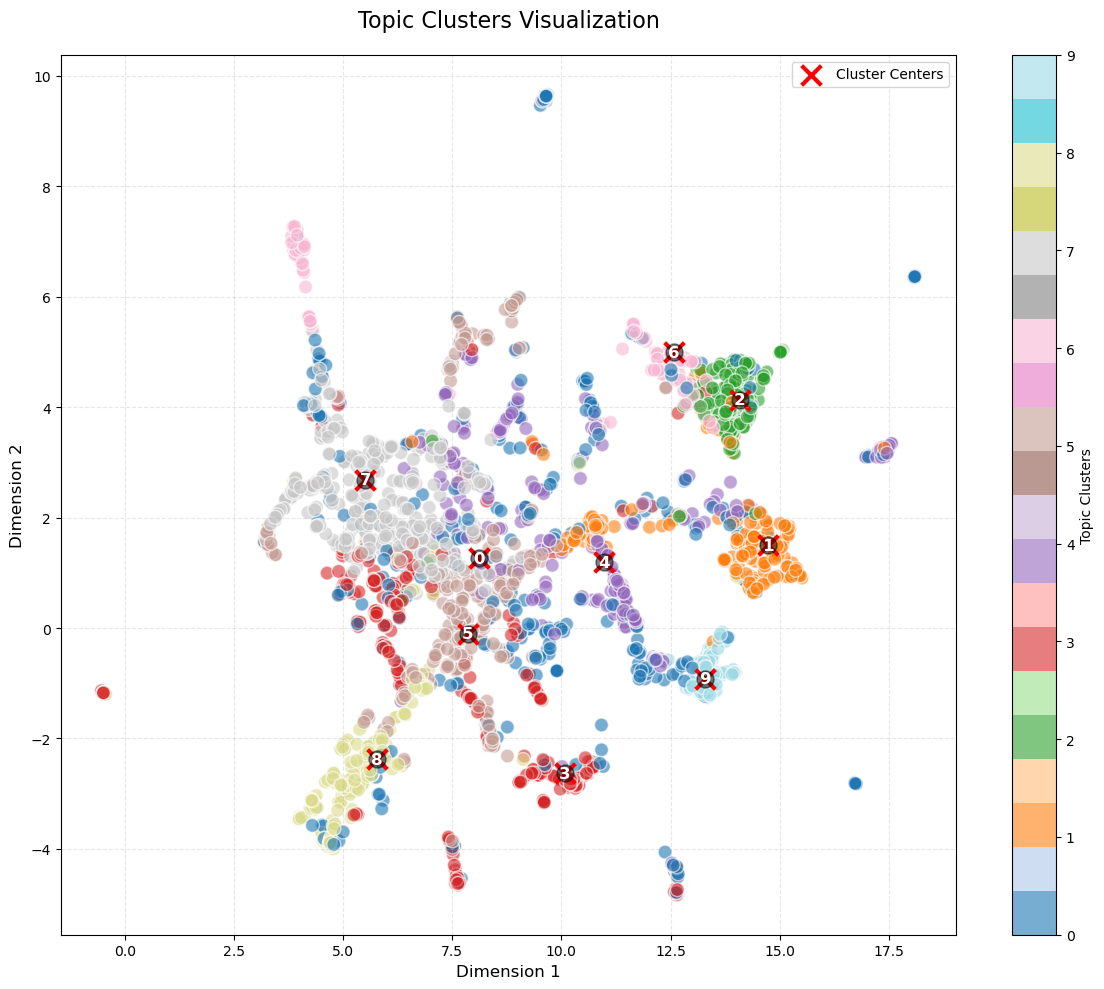

In [50]:
from qdrant_client import QdrantClient
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler

# Connect to Qdrant
client = QdrantClient(url="http://qdrant.homehub.tv")

# Retrieve vectors with payloads
vectors = client.scroll(
    collection_name="chat_history",
    limit=3211,
    with_vectors=True,
    with_payload=True  # Add payload retrieval
)[0]

# Filter out points with empty page_content and convert to numpy array 
filtered_points = [point for point in vectors if point.payload.get('page_content', '').strip()]
vectors_array = np.array([point.vector for point in filtered_points])
payloads = [point.payload.get('title', '') for point in filtered_points]

# Standardize the vectors
scaler = StandardScaler()
vectors_scaled = scaler.fit_transform(vectors_array)

# Perform K-means clustering with more clusters
kmeans = KMeans(n_clusters=10, init='k-means++', n_init=10, random_state=42)
clusters = kmeans.fit_predict(vectors_scaled)

# Replace t-SNE with UMAP
umap = UMAP(n_components=2)
vectors_2d = umap.fit_transform(vectors_scaled)

# Enhanced visualization
plt.figure(figsize=(12, 10))
scatter = plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], 
                     c=clusters, 
                     cmap='tab20',  # More distinct colormap
                     s=100,         # Larger points
                     alpha=0.6,     # Some transparency
                     edgecolor='white')  # White edges for contrast

plt.colorbar(scatter, label='Topic Clusters')
plt.title('Topic Clusters Visualization', fontsize=16, pad=20)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Add cluster centers
centers_2d = umap.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
           c='red', marker='x', s=200, linewidths=3, 
           label='Cluster Centers')

# Label cluster centers with their cluster numbers
for i, (x, y) in enumerate(centers_2d):
    # Add dark background circle
    plt.scatter(x, y, c='black', s=150, alpha=0.5)
    # Add white text on top
    plt.text(x, y, str(i), color='white', fontsize=12, 
             ha='center', va='center', fontweight='bold')

plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter
import numpy as np
from scipy.spatial.distance import cdist

def get_cluster_examples(vectors, clusters, kmeans, method='centroid', n_samples=3):
    examples = {}
    
    for i in range(kmeans.n_clusters):
        cluster_indices = np.where(clusters == i)[0]
        
        if method == 'centroid':
            # Find example closest to cluster centroid
            cluster_vectors = np.array([vectors[idx].vector for idx in cluster_indices])
            distances = cdist(cluster_vectors, [kmeans.cluster_centers_[i]])
            center_idx = cluster_indices[np.argmin(distances)]
            examples[i] = [vectors[center_idx]]
            
        elif method == 'random':
            # Random sampling
            sample_indices = np.random.choice(cluster_indices, min(n_samples, len(cluster_indices)), replace=False)
            examples[i] = [vectors[idx] for idx in sample_indices]
            
        elif method == 'avg_length':
            # Find examples with length close to mean
            lengths = [len(vectors[idx].payload.get('page_content', '').split()) for idx in cluster_indices]
            mean_length = np.mean(lengths)
            sorted_by_length = sorted(cluster_indices, key=lambda idx: abs(len(vectors[idx].payload.get('page_content', '').split()) - mean_length))
            examples[i] = [vectors[idx] for idx in sorted_by_length[:n_samples]]
            
        elif method == 'diversity':
            # Examples with highest unique word count
            def get_unique_words(idx):
                text = vectors[idx].payload.get('page_content', '').lower()
                return len(set(text.split()))
            
            sorted_by_diversity = sorted(cluster_indices, key=get_unique_words, reverse=True)
            examples[i] = [vectors[idx] for idx in sorted_by_diversity[:n_samples]]
    
    return examples

def clean_text(text):
    # Remove markdown characters
    markdown_chars = ['*', '#', '_', '-', '`', '[', ']', '(', ')', '>', '|']
    for char in markdown_chars:
        text = text.replace(char, '')
    
    # Replace newlines with spaces and remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

# Usage example:
examples = get_cluster_examples(vectors, clusters, kmeans, method='avg_length', n_samples=3)
for cluster_id, cluster_examples in examples.items():
    print(f"\nCluster {cluster_id}:")
    for ex in cluster_examples:
        content = clean_text(ex.payload.get('page_content', 'No content available'))
        print(f"\n- {content[:2000]}...")
